# Filter study for Cryoscope

**Goal**: Understand action of savgol filter

This notebook contains some tests that were made on changing the parameters of the savgol filters, in particular varying the window length. 
We also tried not to apply demodulation and see how the phase changes depending on this

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal

from pathlib import Path
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.signal import lfilter

from qibocal.protocols.two_qubit_interaction.cryoscope import _plot, CryoscopeData, CryoscopeResults, CryoscopeType 
from qibocal.protocols.ramsey.utils import fitting


FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(50), np.zeros(10)])


[Qibo 0.2.12|INFO|2024-12-02 11:52:12]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-02 11:52:12]: Loading platform dummy


In [2]:
def compute_window_length(data: CryoscopeData, savgol: bool, demod: bool):

    fitted_parameters = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        x = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(x, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (x[1] - x[0])

        # to be used in savgol_filter
        derivative_window_length = 3 / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        derivative_window_size += (derivative_window_size + 1) % 2

    return(derivative_window_size)

In [17]:
def _fit(data: CryoscopeData, savgol: bool, demod: bool) -> CryoscopeResults:

    nyquist_order = 0

    fitted_parameters = {}
    detuning = {}
    amplitude = {}
    step_response = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        x = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(x, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (x[1] - x[0])
        X_exp = 1 - 2 * data[(qubit, "MX")].prob_1
        Y_exp = 1 - 2 * data[(qubit, "MY")].prob_1

        norm_data = X_exp + 1j * Y_exp

        # demodulation frequency found by fitting sinusoidal
        demod_freq = -fitted_parameters[qubit, "MY"][2] / 2 / np.pi * sampling_rate

        # to be used in savgol_filter
        derivative_window_length = 10 / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        #derivative_window_size += (derivative_window_size + 1) % 2

        # find demodulatation frequency
        if demod:
            demod_data = np.exp(2 * np.pi * 1j * x * demod_freq) * (norm_data)
        else:
            demod_data = norm_data
            
        # compute phase
        phase = np.unwrap(np.angle(demod_data))

        # compute detuning

        if savgol:
            phase = scipy.signal.savgol_filter(
                phase / (2 * np.pi),
                window_length=derivative_window_size,
                polyorder=2,
                deriv=1,
                )
            raw_detuning = (phase * sampling_rate
            )
        else:
            phase = phase/(2*np.pi)
            raw_detuning = (phase*sampling_rate)

        # real detuning (reintroducing demod_freq)
        detuning[qubit] = (
            raw_detuning - demod_freq + sampling_rate * nyquist_order
        ).tolist()

        # params from flux_amplitude_frequency_protocol
        params = [1.9412681243469971, -0.012534948170662627, 0.0005454772278201887]


        # invert frequency amplitude formula
        p = np.poly1d(params)
        amplitude[qubit] = [max((p - freq).roots).real for freq in detuning[qubit]]

        # compute step response
        step_response[qubit] = (
            np.array(amplitude[qubit]) / data.flux_pulse_amplitude
        ).tolist()

    return CryoscopeResults(
        amplitude=amplitude,
        detuning=detuning,
        step_response=step_response,
        fitted_parameters=fitted_parameters,
    ), raw_detuning, phase

**Loading data**

In [12]:
def load_cryoscope_data(file_path: str, flux_pulse_amplitude: float) -> CryoscopeData:

    cryoscope_data = CryoscopeData(flux_pulse_amplitude = flux_pulse_amplitude)
    
    data_npz = np.load(file_path)
    D1MX = np.rec.array(data_npz['["D1", "MX"]'])
    D1MY = np.rec.array(data_npz['["D1", "MY"]'])
    
    data_dict = {
        ("D1", "MX") : D1MX,
        ("D1", "MY") : D1MY
    }

    cryoscope_data.data = data_dict

    return cryoscope_data


In [13]:
# Load data
data_path = Path.cwd().parent / "cryo_material" / "cryoscope" / "data" / "cryoscope-0"
results_json = data_path / "results.json"
data_json = data_path / "data.json"

with open(data_json, "r") as file:
    data = json.load(file)

with open(results_json, "r") as file:
    results = json.load(file)

print(data)
print(results)

{'"flux_pulse_amplitude"': 0.1}
{'"fitted_parameters"': {'["D1", "MX"]': [-0.00029639988763097147, 0.9259233868264589, 0.11297702572931177, 0.6811588111300295, 0.000200444727454511], '["D1", "MY"]': [-0.04330729231685593, 0.8053304242090724, 0.10001152244951339, -0.4561057364051088, 2.2940053954883843e-20]}, '"detuning"': {'"D1"': [0.0009089261001269961, 0.000771851252188812, 0.0006347764042506296, 0.0004977015563124541, 0.0006846099963171426, 0.0013814410767795885, 0.0009524330694135, 0.0020828945176104875, 0.00451965116963066, 0.008056748847200531, 0.010930627775662245, 0.01474036564921474, 0.01760471010827338, 0.018092453186971134, 0.018848063875241225, 0.019652778635600485, 0.020640357880029162, 0.020271250427942165, 0.020203698291166236, 0.020596376668128507, 0.020954302520328046, 0.021055945473469714, 0.020656135007137394, 0.019722949412587443, 0.018482234744427915, 0.017193251219308283, 0.016571813635514302, 0.01759950666098585, 0.018236536283483897, 0.0190546229767291, 0.019108

In [14]:
flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", flux_pulse_amplitude)

### Default savgol filter values

In [15]:
#applicazione del filtro sui dati demodulati vs non demodulati
_, _, savgol_demod = _fit(cryoscope_data, True, True)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False)

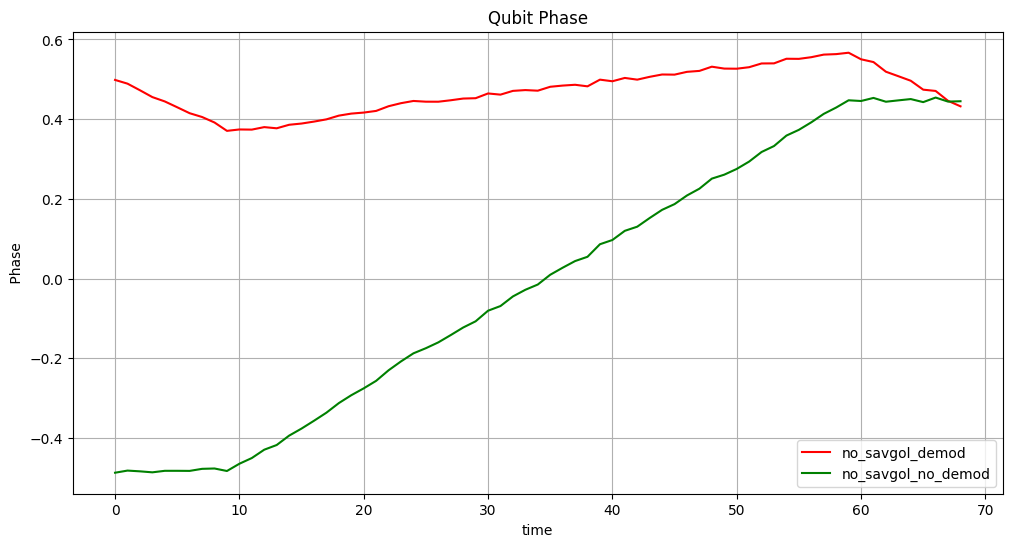

In [8]:
plt.figure(figsize=(12, 6)) 
plt.plot(no_savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(no_savgol_no_demod, color = "green", label="no_savgol_no_demod")
plt.xlabel("time")
plt.ylabel(" Phase ")
plt.title("Qubit Phase")
plt.legend()
plt.grid()
plt.show()

In the following plot we simply try to apply the gradient on the phase instead of applying the savgol filter. The `edge_order` parameters simply refers on how derivative is computed at the domain edge

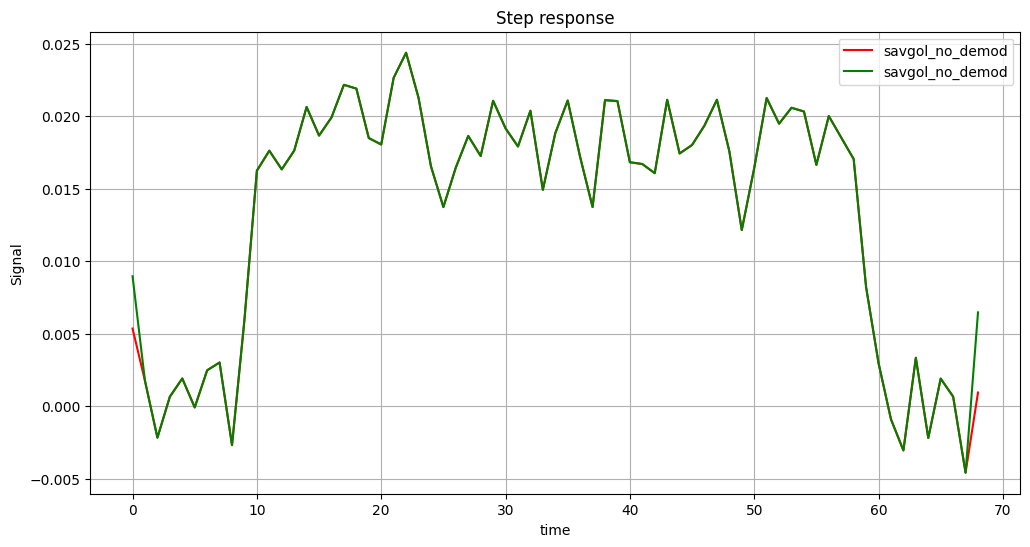

In [9]:
plt.figure(figsize=(12, 6)) 
plt.plot(np.gradient(no_savgol_no_demod, edge_order=1), color = "red", label="savgol_no_demod")
plt.plot(np.gradient(no_savgol_no_demod, edge_order=2), color = "green", label="savgol_no_demod")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

The following plot shows the plot of the phase after the application of a `savgol` filter (with standard parameters so window length 7).

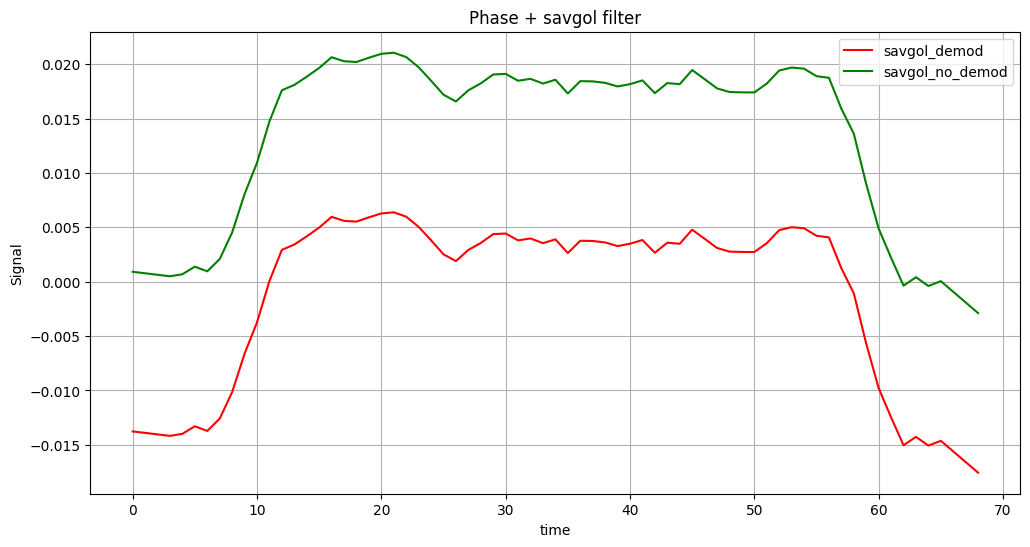

In [16]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="savgol_demod")
plt.plot(savgol_no_demod, color = "green", label="savgol_no_demod")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Phase + savgol filter")
plt.legend()
plt.grid()
plt.show()

### Changing savgol filter values

The following plot shows the plot of the phase after the application of a `savgol` filter changing the window length to 10.

In [18]:
#applicazione del filtro sui dati demodulati vs non demodulati

# derivative_window_length = 10/sampling_frequence

_, _, savgol_demod = _fit(cryoscope_data, True, True)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False)

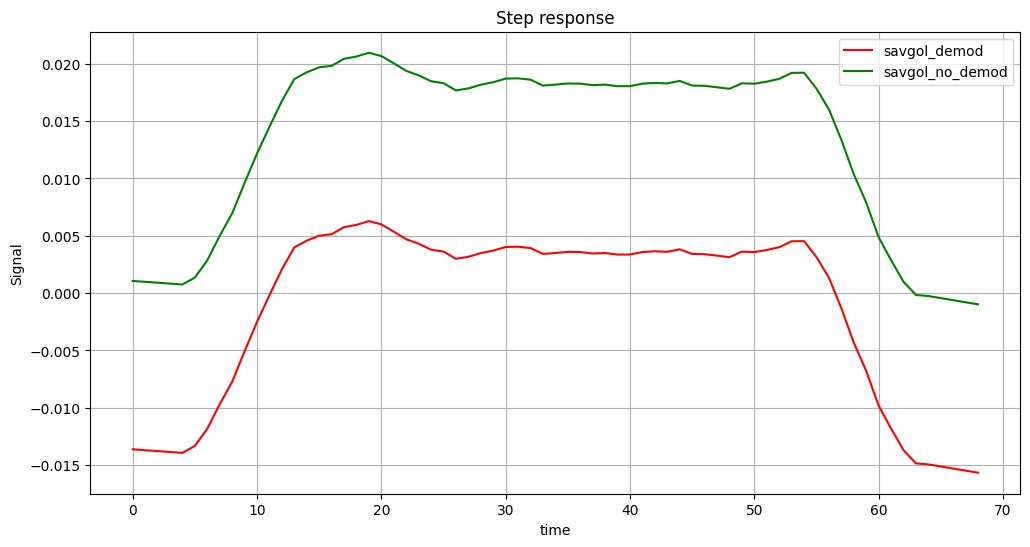

In [19]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="savgol_demod")
plt.plot(savgol_no_demod, color = "green", label="savgol_no_demod")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

The following plot shows the plot of the phase after the application of a `savgol` filter changing the window length to 3.

In [ ]:
#applicazione del filtro sui dati demodulati vs non demodulati

# derivative_window_length = 3/sampling_rate

_, _, savgol_demod = _fit(cryoscope_data, True, True)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False)

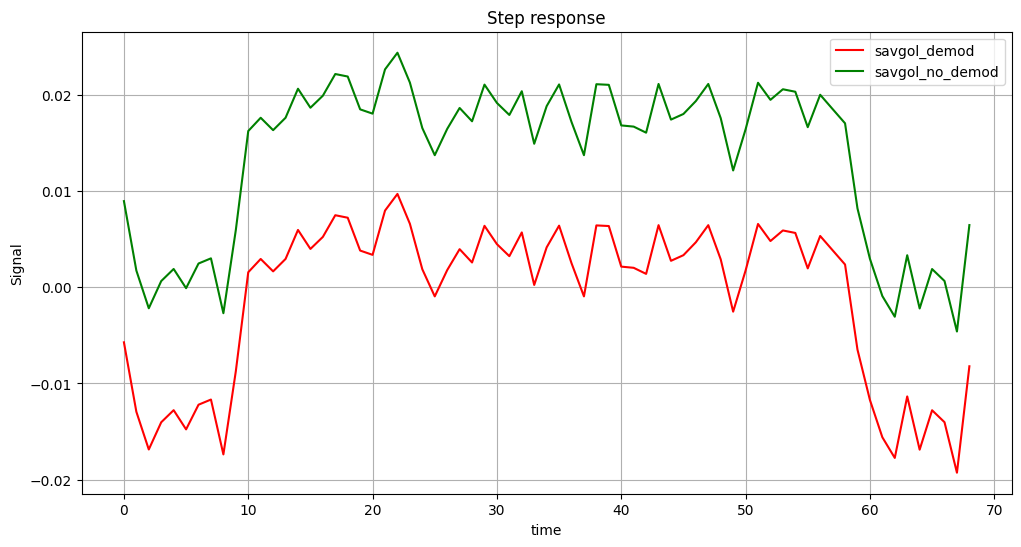

In [37]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="savgol_demod")
plt.plot(savgol_no_demod, color = "green", label="savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

### Considerations on window length and on `savgol` filter in general

In [26]:
def compute_window_length(data: CryoscopeData, savgol: bool, demod: bool):

    fitted_parameters = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        x = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(x, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (x[1] - x[0])

        # to be used in savgol_filter
        derivative_window_length = 7 / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        derivative_window_size += (derivative_window_size + 1) % 2

    return(derivative_window_size, sampling_rate)

In [27]:
compute_window_length(cryoscope_data, False, False)

(7, 1.0)

In [32]:
from scipy.signal import savgol_filter
import numpy as np

x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, 100)

smoothed_y = savgol_filter(y, window_length=11, polyorder=3)
smoothed_y_ord2 = savgol_filter(y, window_length=10, polyorder=2)

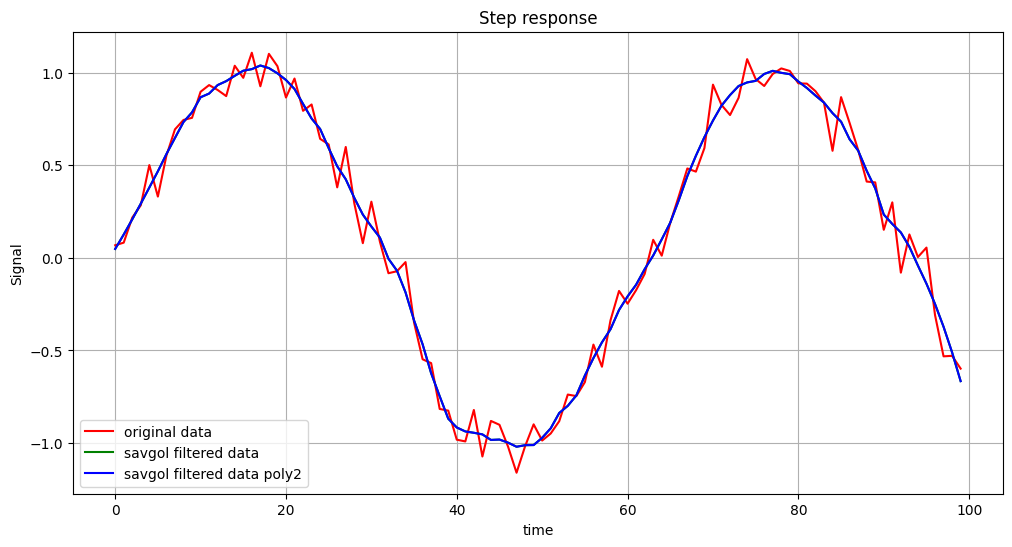

In [33]:
plt.figure(figsize=(12, 6)) 
plt.plot(y, color = "red", label="original data")
plt.plot(smoothed_y, color = "green", label="savgol filtered data")
plt.plot(smoothed_y, color = "blue", label="savgol filtered data poly2")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()